In [3]:
# Create env
# conda create --name ESL python=3.11
# Install required libraries if not already installed
# !pip install numpy matplotlib scipy scikit-learn


In [ ]:
# === Figure 2.4 recreation (Elements of Statistical Learning, §2.3) ===
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det
from scipy.stats import multivariate_normal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression


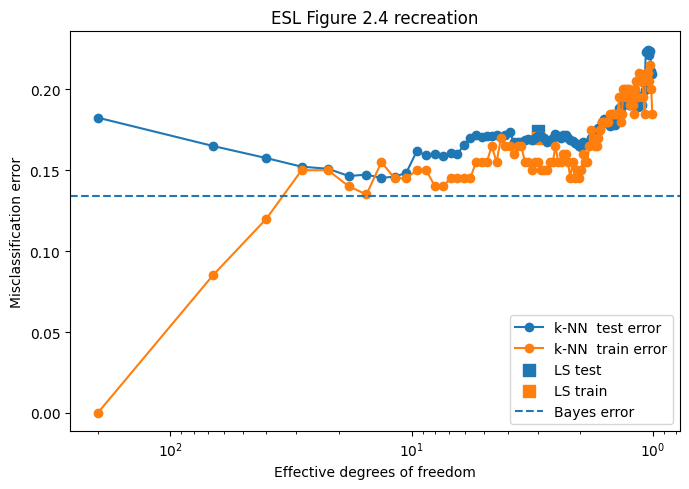

In [7]:

# ---------------------------------------------------------------------
# 1.  Simulation settings
# ---------------------------------------------------------------------
rng              = np.random.default_rng(42)   # reproducibility
n_clusters       = 10          # per class
cluster_cov      = np.eye(2)   # I  (for the cluster means)
obs_cov          = np.eye(2)/5 # I/5  (for individual observations)
n_per_class      = 100         # training obs per class
n_test_per_class = 5000        # test obs per class
train_size       = 2 * n_per_class
test_size        = 2 * n_test_per_class
ks               = np.arange(1, 200, 2)        # odd k for k-NN

# ---------------------------------------------------------------------
# 2.  Generate 10 cluster means for each class
# ---------------------------------------------------------------------
mean_blue   = np.array([1.0, 0.0])
mean_orange = np.array([0.0, 1.0])

M_blue   = rng.multivariate_normal(mean_blue,   cluster_cov, n_clusters)
M_orange = rng.multivariate_normal(mean_orange, cluster_cov, n_clusters)

# helper: draw a sample of size n from mixture defined by cluster means M
def sample_from_mixture(M, n):
    """Draw n points: pick a cluster uniformly, then x ~ N(m_k, I/5)."""
    idx  = rng.choice(len(M), size=n, replace=True)
    mus  = M[idx]
    obs  = mus + rng.multivariate_normal(np.zeros(2), obs_cov, n)
    return obs

# ---------------------------------------------------------------------
# 3.  Training and test sets
# ---------------------------------------------------------------------
X_train_blue   = sample_from_mixture(M_blue,   n_per_class)
X_train_orange = sample_from_mixture(M_orange, n_per_class)
X_train        = np.vstack([X_train_blue, X_train_orange])
y_train        = np.concatenate([np.zeros(n_per_class, dtype=int),
                                 np.ones (n_per_class, dtype=int)])

X_test_blue    = sample_from_mixture(M_blue,   n_test_per_class)
X_test_orange  = sample_from_mixture(M_orange, n_test_per_class)
X_test         = np.vstack([X_test_blue, X_test_orange])
y_test         = np.concatenate([np.zeros(n_test_per_class, dtype=int),
                                 np.ones (n_test_per_class, dtype=int)])

# ---------------------------------------------------------------------
# 4.  k-NN classification over a range of k
# ---------------------------------------------------------------------
train_err = []
test_err  = []
dfs       = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    yhat_tr = knn.predict(X_train)
    yhat_te = knn.predict(X_test)
    
    train_err.append((yhat_tr != y_train).mean())
    test_err .append((yhat_te != y_test ).mean())
    dfs.append(train_size / k)          # ESL definition of df for k-NN

train_err = np.array(train_err)
test_err  = np.array(test_err)
dfs       = np.array(dfs)

# ---------------------------------------------------------------------
# 5.  Least-squares classifier (linear regression, df = 3)
# ---------------------------------------------------------------------
regr = LinearRegression()
regr.fit(X_train, y_train)             # y coded 0/1
yhat_tr_lr = (regr.predict(X_train) >= 0.5).astype(int)
yhat_te_lr = (regr.predict(X_test ) >= 0.5).astype(int)

train_err_lr = (yhat_tr_lr != y_train).mean()
test_err_lr  = (yhat_te_lr != y_test ).mean()
df_lr        = 3.0                     # intercept + 2 coefficients

# ---------------------------------------------------------------------
# 6.  (Approximate) Bayes optimal error
# ---------------------------------------------------------------------
def mixture_pdf(x, M):
    """Density under mixture of N(m_k, I/5) with equal weights."""
    mvn = multivariate_normal(mean=np.zeros(2), cov=obs_cov)
    # exploit the fact cov is same for all clusters
    log_vals = []
    for m in M:
        log_vals.append(mvn.logpdf(x - m))
    # log(sum(exp())) in a stable way
    return np.exp(np.logaddexp.reduce(log_vals) - np.log(len(M)))

# compute Bayes error on test sample
pdf_blue   = np.array([mixture_pdf(x, M_blue  ) for x in X_test])
pdf_orange = np.array([mixture_pdf(x, M_orange) for x in X_test])
bayes_pred = (pdf_orange > pdf_blue).astype(int)
bayes_err  = (bayes_pred != y_test).mean()

# ---------------------------------------------------------------------
# 7.  Plot (matches ESL Figure 2.4)
# ---------------------------------------------------------------------
plt.figure(figsize=(7, 5))
plt.plot(dfs, test_err,  '-o', label='k-NN  test error')   # default color = orange
plt.plot(dfs, train_err, '-o', label='k-NN  train error')  # default color = blue

plt.scatter([df_lr], [test_err_lr],  marker='s', s=80, label='LS test')
plt.scatter([df_lr], [train_err_lr], marker='s', s=80, label='LS train')

plt.axhline(bayes_err, linestyle='--', linewidth=1.5, label='Bayes error')

plt.xscale('log')
plt.gca().invert_xaxis()           # decreasing df (like ESL figure)
plt.xlabel('Effective degrees of freedom')
plt.ylabel('Misclassification error')
plt.title('ESL Figure 2.4 recreation')
plt.legend()
plt.tight_layout()
plt.show()
